<a href="https://colab.research.google.com/github/Benson-G/Project/blob/main/House_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chennai House Price Prediction

#Importing Python Packages

In [1]:
import pandas as pd
import numpy as np
import math
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid")

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
from sklearn.datasets import make_regression
from sklearn.svm import SVR
from sklearn.datasets import make_regression
from sklearn import tree
import xgboost as xgb

In [2]:
data = pd.read_csv("/content/train-chennai-sale.csv")
pd.set_option('display.max_columns', None)
data.head(5)

,PRT_ID,AREA,INT_SQFT,DATE_SALE,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,SALE_COND,PARK_FACIL,DATE_BUILD,BUILDTYPE,UTILITY_AVAIL,STREET,MZZONE,QS_ROOMS,QS_BATHROOM,QS_BEDROOM,QS_OVERALL,REG_FEE,COMMIS,SALES_PRICE
0,P03210,Karapakkam,1004,04-05-2011,131,1.0,1.0,3,AbNormal,Yes,15-05-1967,Commercial,AllPub,Paved,A,4.0,3.9,4.9,4.330,380000,144400,7600000
1,P09411,Anna Nagar,1986,19-12-2006,26,2.0,1.0,5,AbNormal,No,22-12-1995,Commercial,AllPub,Gravel,RH,4.9,4.2,2.5,3.765,760122,304049,21717770
2,P01812,Adyar,909,04-02-2012,70,1.0,1.0,3,AbNormal,Yes,09-02-1992,Commercial,ELO,Gravel,RL,4.1,3.8,2.2,3.090,421094,92114,13159200
3,P05346,Velachery,1855,13-03-2010,14,3.0,2.0,5,Family,No,18-03-1988,Others,NoSewr,Paved,I,4.7,3.9,3.6,4.010,356321,77042,9630290
4,P06210,Karapakkam,1226,05-10-2009,84,1.0,1.0,3,AbNormal,Yes,13-10-1979,Others,AllPub,Gravel,C,3.0,2.5,4.1,3.290,237000,74063,7406250


#Data Cleaning

In [3]:
data.dropna(inplace=True)

data.columns = data.columns.str.lower()

data.area = data.area.str.lower()

data.area = data.area.replace({'velchery':'velachery', 
                       'kknagar':'kk nagar', 
                       'tnagar':'t nagar', 
                       'chormpet':'chrompet', 
                       'chrompt':'chrompet', 
                       'chrmpet':'chrompet', 
                       'ana nagar':'anna nagar', 
                       'ann nagar':'anna nagar',
                       'karapakam':'karapakkam', 
                       'adyr':'adyar'})

data.sale_cond = data.sale_cond.str.lower()

data.sale_cond = data.sale_cond.replace({'adj land':'adjland',               
                       'partiall':'partial',
                       'ab normal':'abnormal'})

data.park_facil = data.park_facil.str.lower()

data.park_facil = data.park_facil.replace({'noo':'no'})

data.buildtype = data.buildtype.str.lower()

data.buildtype = data.buildtype.replace({'comercial':'commercial', 
                       'others':'other'})

data.utility_avail = data.utility_avail.str.lower()

data.utility_avail = data.utility_avail.replace({'all pub':'allpub',
                                             'nosewr':'nosewa'})
                                            
data.street = data.street.str.lower()

data.street = data.street.replace({'pavd':'paved', 
                       'noaccess':'no access'})

data.mzzone = data.mzzone.str.lower()

data.n_bedroom = data.n_bedroom.astype(int)
data.n_bathroom = data.n_bathroom.astype(int)

data.date_sale = pd.to_datetime(data.date_sale, format='%d-%m-%Y')
data.date_build = pd.to_datetime(data.date_build, format='%d-%m-%Y')

data['property_age'] = pd.DatetimeIndex(data.date_sale).year - pd.DatetimeIndex(data.date_build).year

data.drop(columns=['reg_fee', 'commis'])

data = data.reindex(columns = ['prt_id', 'area', 'sale_cond', 'park_facil',
       'buildtype', 'utility_avail', 'street', 'mzzone', 
       'date_build', 'date_sale', 'property_age', 
       'int_sqft', 'dist_mainroad', 'n_bedroom','n_bathroom', 'n_room', 
       'qs_rooms', 'qs_bathroom', 'qs_bedroom', 'qs_overall', 
       'reg_fee', 'commis', 'sales_price'])

data.head(10)

,prt_id,area,sale_cond,park_facil,buildtype,utility_avail,street,mzzone,date_build,date_sale,property_age,int_sqft,dist_mainroad,n_bedroom,n_bathroom,n_room,qs_rooms,qs_bathroom,qs_bedroom,qs_overall,reg_fee,commis,sales_price
0,P03210,karapakkam,abnormal,yes,commercial,allpub,paved,a,1967-05-15,2011-05-04,44,1004,131,1,1,3,4.0,3.9,4.9,4.330,380000,144400,7600000
1,P09411,anna nagar,abnormal,no,commercial,allpub,gravel,rh,1995-12-22,2006-12-19,11,1986,26,2,1,5,4.9,4.2,2.5,3.765,760122,304049,21717770
2,P01812,adyar,abnormal,yes,commercial,elo,gravel,rl,1992-02-09,2012-02-04,20,909,70,1,1,3,4.1,3.8,2.2,3.090,421094,92114,13159200
3,P05346,velachery,family,no,other,nosewr,paved,i,1988-03-18,2010-03-13,22,1855,14,3,2,5,4.7,3.9,3.6,4.010,356321,77042,9630290
4,P06210,karapakkam,abnormal,yes,other,allpub,gravel,c,1979-10-13,2009-10-05,30,1226,84,1,1,3,3.0,2.5,4.1,3.290,237000,74063,7406250
5,P00219,chrompet,partial,no,commercial,nosewa,no access,rh,2009-09-12,2014-09-11,5,1220,36,2,1,4,4.5,2.6,3.1,3.320,409027,198316,12394750
6,P09105,chrompet,partial,no,other,allpub,no access,rl,1979-04-12,2007-04-05,28,1167,137,1,1,3,3.6,2.1,2.5,2.670,263152,33955,8488790
7,P09679,velachery,family,no,commercial,allpub,gravel,rm,1996-03-15,2006-03-13,10,1847,176,3,2,5,2.4,4.5,2.1,3.260,604809,235204,16800250
8,P03377,chrompet,adjland,no,other,nosewr,paved,rm,1977-04-14,2011-04-06,34,771,175,1,1,2,2.9,3.7,4.0,3.550,257578,33236,8308970
9,P09623,velachery,abnormal,no,other,elo,no access,i,1991-06-26,2006-06-22,15,1635,74,2,1,4,3.1,3.1,3.3,3.160,323346,121255,8083650


#EDA

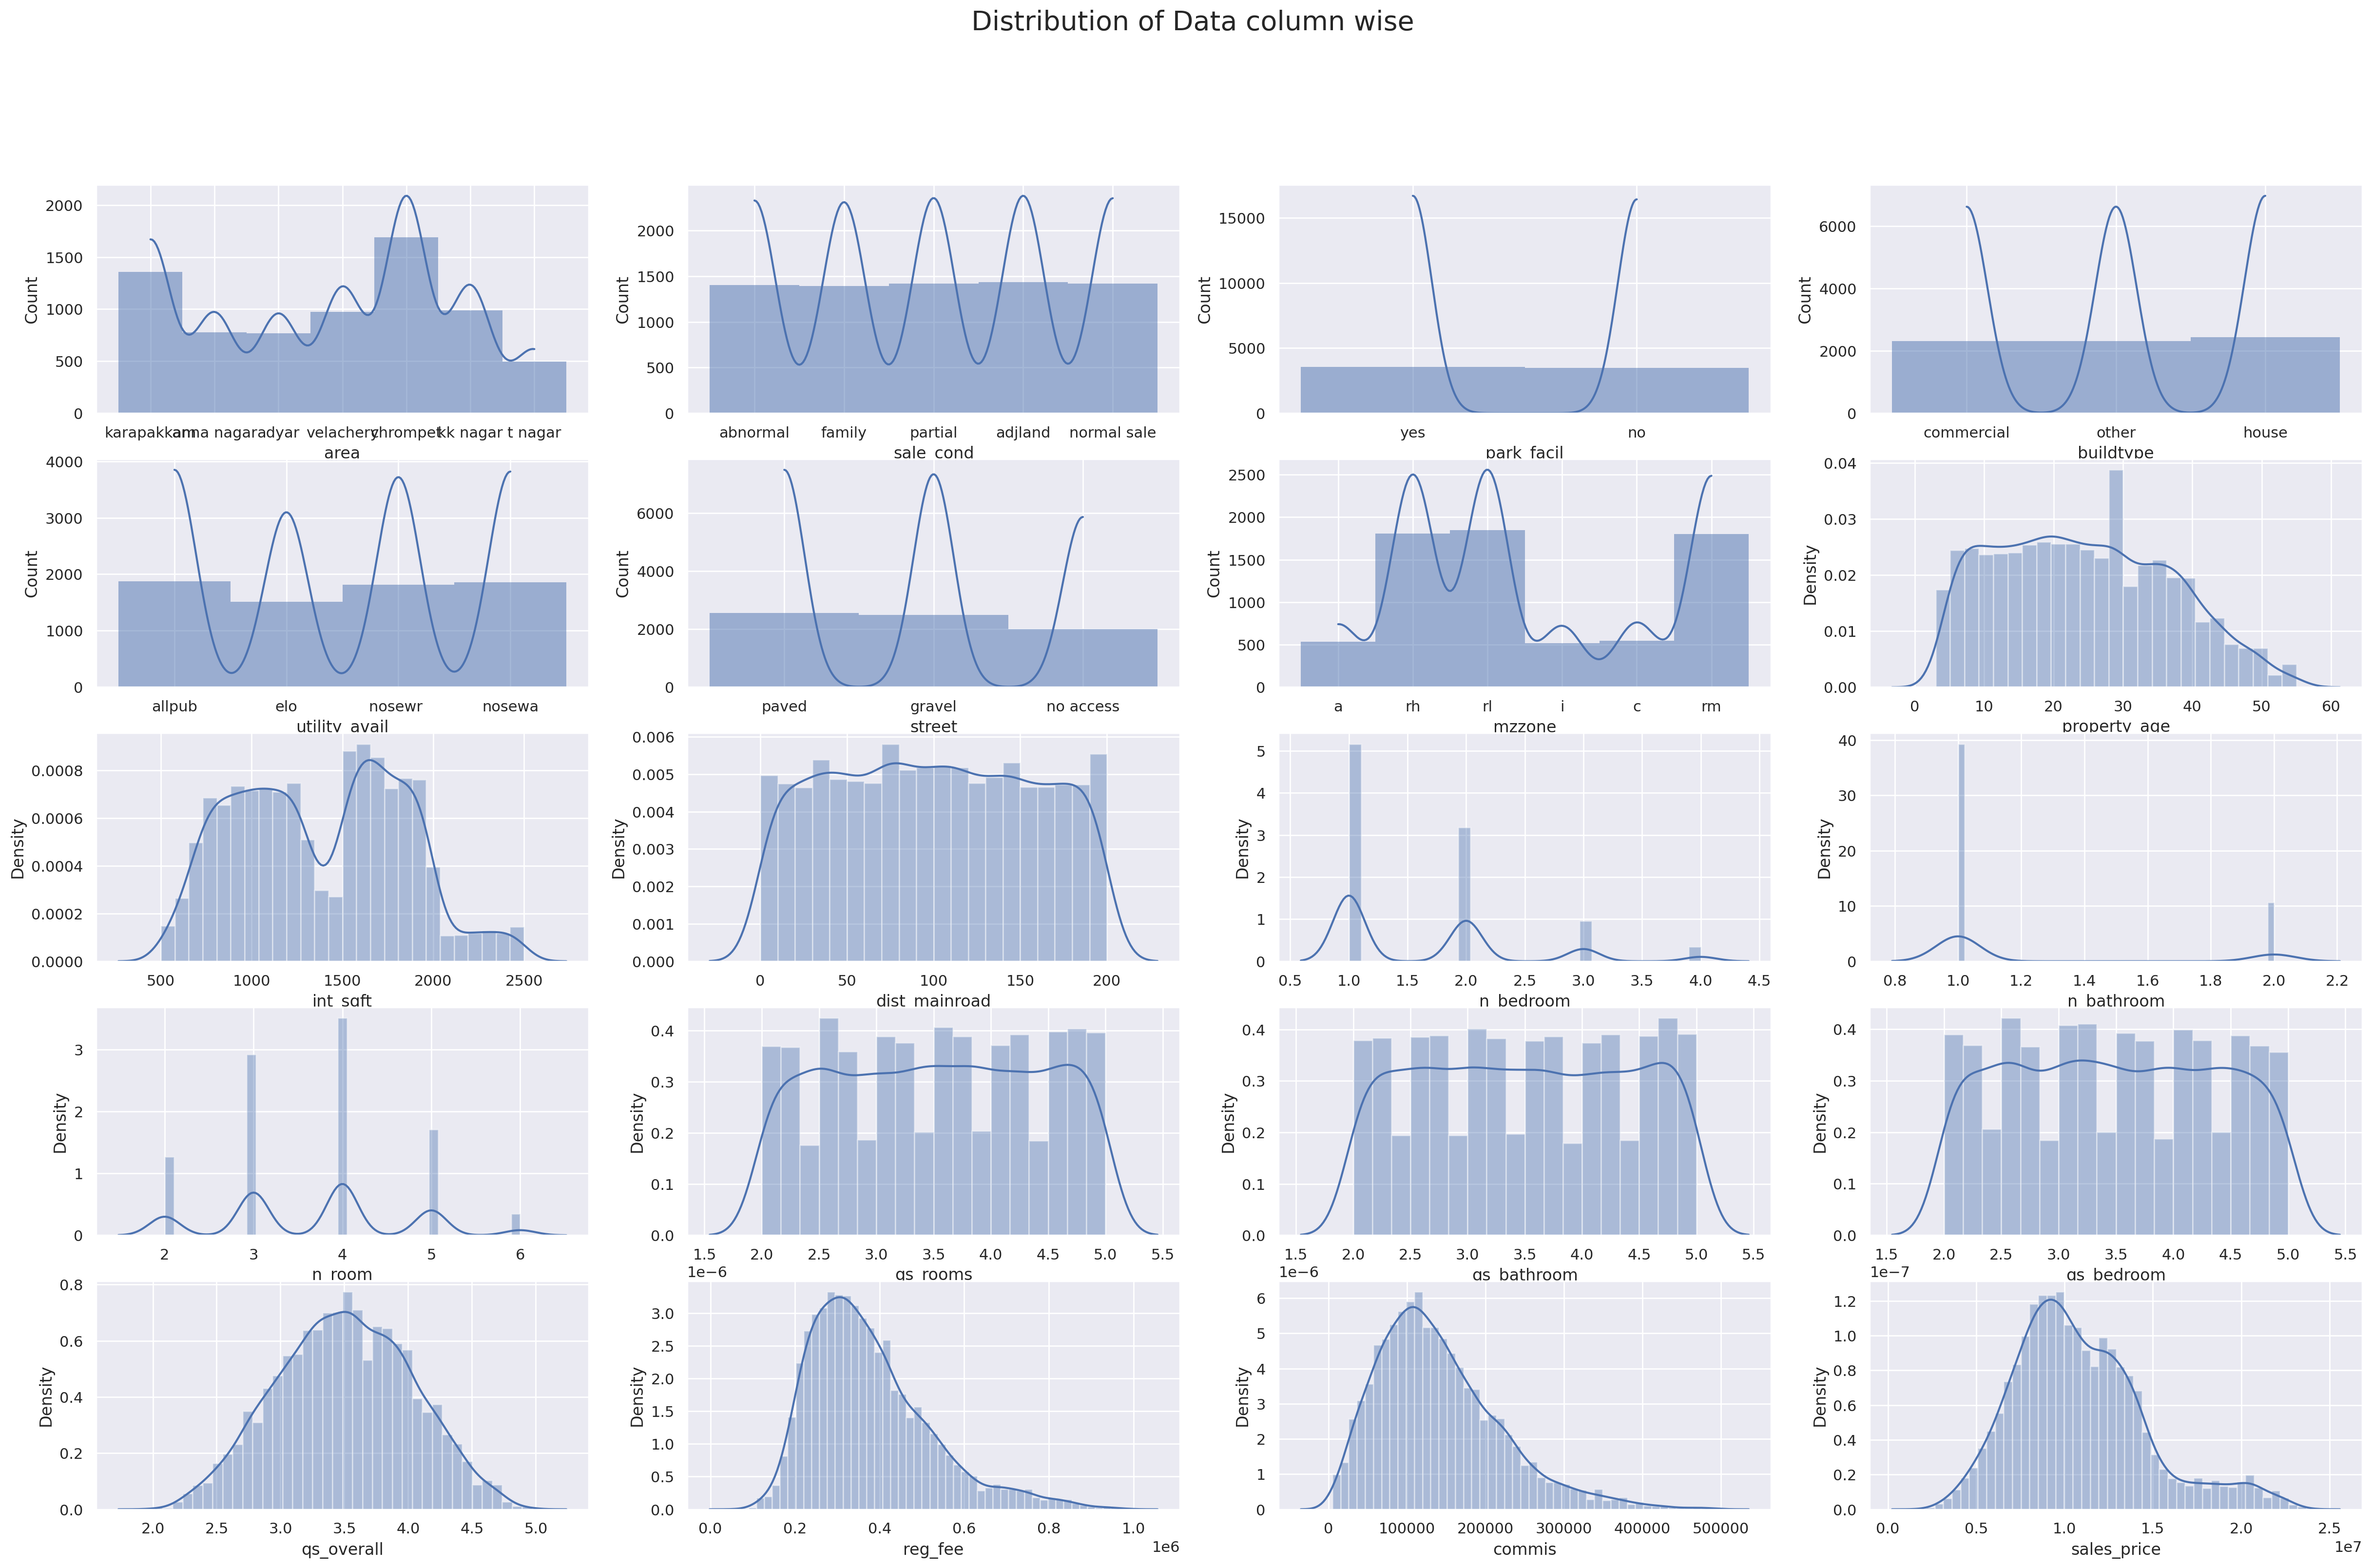

In [4]:
plt.figure(figsize=(30, 18), dpi=200)

plt.subplot(5,4,1)
sns.histplot(data.area, linewidth=0,kde=True)

plt.subplot(5,4,2)
sns.histplot(data.sale_cond, linewidth=0,kde=True)

plt.subplot(5,4,3)
sns.histplot(data.park_facil, linewidth=0,kde=True)

plt.subplot(5,4,4)
sns.histplot(data.buildtype, linewidth=0,kde=True)

plt.subplot(5,4,5)
sns.histplot(data.utility_avail, linewidth=0,kde=True)

plt.subplot(5,4,6)
sns.histplot(data.street, linewidth=0,kde=True)

plt.subplot(5,4,7)
sns.histplot(data.mzzone, linewidth=0,kde=True)

plt.subplot(5,4,8)
sns.distplot(data.property_age)

plt.subplot(5,4,9)
sns.distplot(data.int_sqft)

plt.subplot(5,4,10)
sns.distplot(data.dist_mainroad)

plt.subplot(5,4,11)
sns.distplot(data.n_bedroom)

plt.subplot(5,4,12)
sns.distplot(data.n_bathroom)

plt.subplot(5,4,13)
sns.distplot(data.n_room)

plt.subplot(5,4,14)
sns.distplot(data.qs_rooms)

plt.subplot(5,4,15)
sns.distplot(data.qs_bathroom)

plt.subplot(5,4,16)
sns.distplot(data.qs_bedroom)

plt.subplot(5,4,17)
sns.distplot(data.qs_overall)

plt.subplot(5,4,18)
sns.distplot(data.reg_fee)

plt.subplot(5,4,19)
sns.distplot(data.commis)

plt.subplot(5,4,20)
sns.distplot(data.sales_price)

plt.suptitle("Distribution of Data column wise", fontsize=20)
plt.show()

In [5]:
data.groupby('area')['sales_price'].mean().reset_index().sort_values('sales_price')['area']

3    karapakkam
0         adyar
2      chrompet
6     velachery
4      kk nagar
1    anna nagar
5       t nagar
Name: area, dtype: object

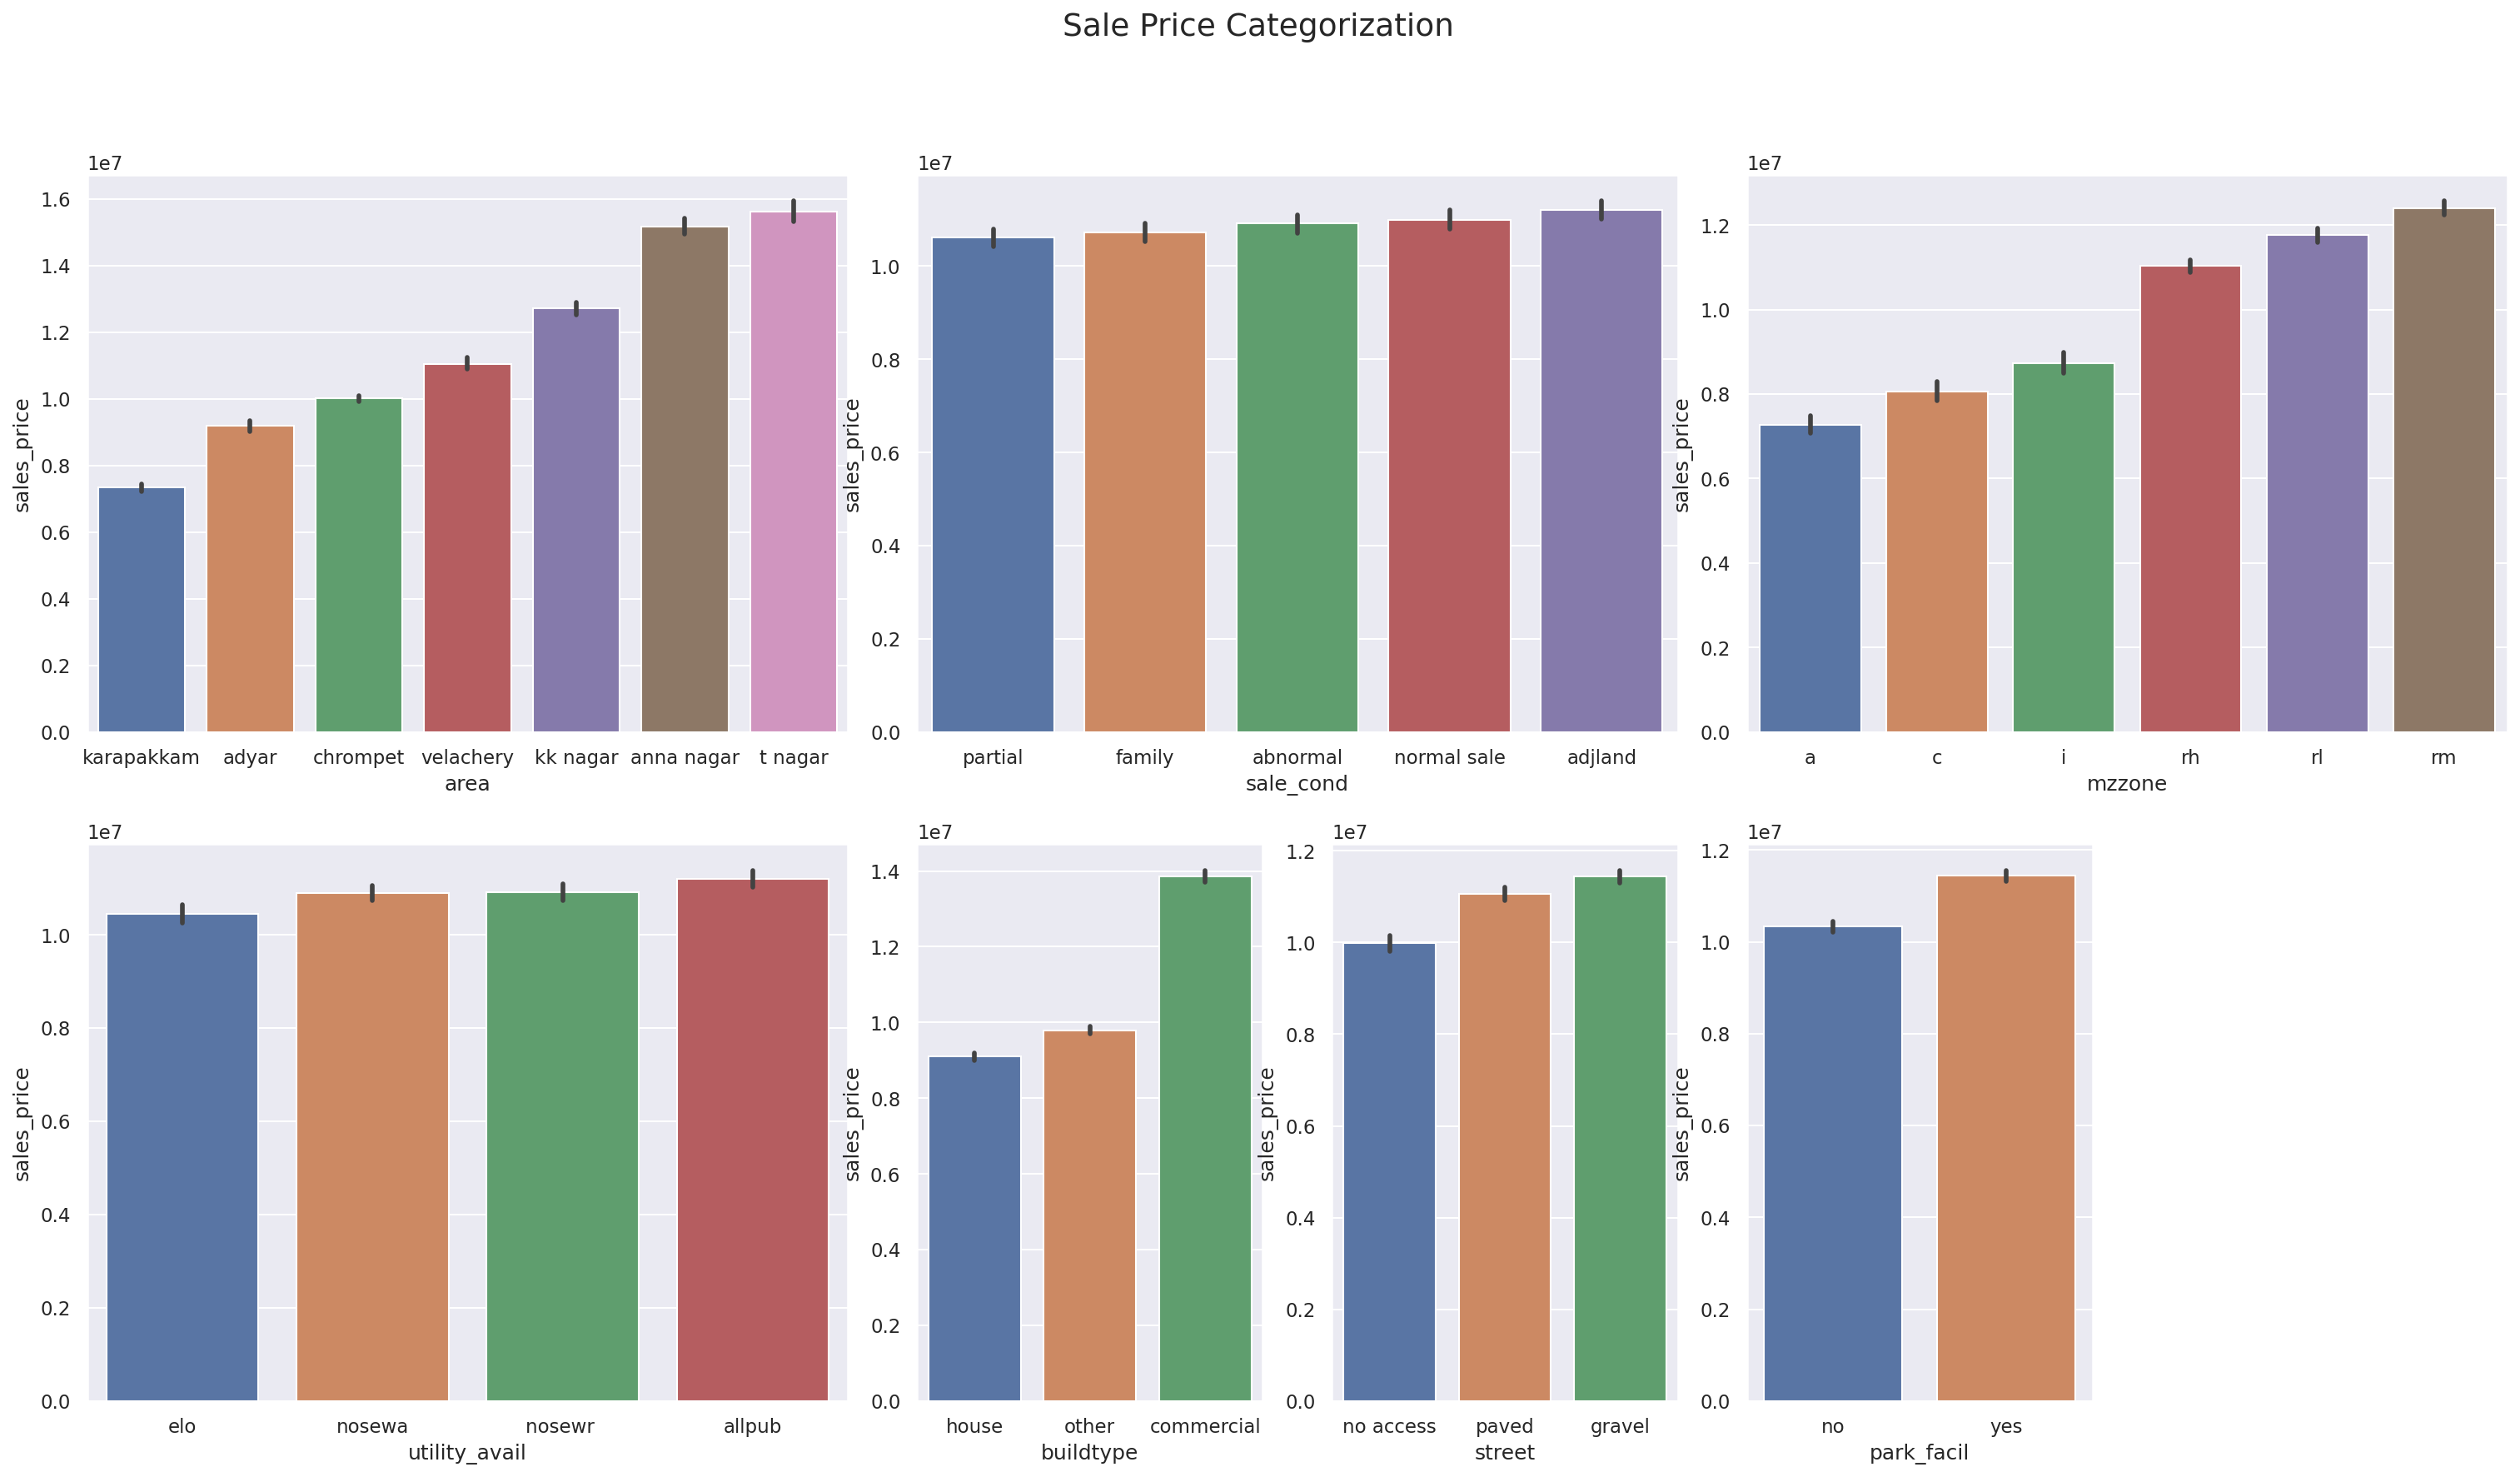

In [6]:
plt.figure(figsize=(25, 13), dpi=150)

plt.subplot2grid((2,6),(0,0),colspan=2)
sns.barplot(x=data.area,y=data.sales_price,order=data.groupby('area')['sales_price'].mean().reset_index().sort_values('sales_price')['area'])

plt.subplot2grid((2,6),(0,2),colspan=2)
sns.barplot(x=data.sale_cond,y=data.sales_price,order=data.groupby('sale_cond')['sales_price'].mean().reset_index().sort_values('sales_price')['sale_cond'])

plt.subplot2grid((2,6),(0,4),colspan=2)
sns.barplot(x=data.mzzone,y=data.sales_price,order=data.groupby('mzzone')['sales_price'].mean().reset_index().sort_values('sales_price')['mzzone'])

plt.subplot2grid((2,6),(1,0),colspan=2)
sns.barplot(x=data.utility_avail,y=data.sales_price,order=data.groupby('utility_avail')['sales_price'].mean().reset_index().sort_values('sales_price')['utility_avail'])

plt.subplot2grid((2,6),(1,2))
sns.barplot(x=data.buildtype,y=data.sales_price,order=data.groupby('buildtype')['sales_price'].mean().reset_index().sort_values('sales_price')['buildtype'])

plt.subplot2grid((2,6),(1,3))
sns.barplot(x=data.street,y=data.sales_price,order=data.groupby('street')['sales_price'].mean().reset_index().sort_values('sales_price')['street'])

plt.subplot2grid((2,6),(1,4))
sns.barplot(x=data.park_facil,y=data.sales_price,order=data.groupby('park_facil')['sales_price'].mean().reset_index().sort_values('sales_price')['park_facil'])

plt.suptitle("Sale Price Categorization", fontsize=18)
plt.show()

In [7]:
data = pd.get_dummies(data,columns=['buildtype'])

#label Encoding

In [8]:

data.area = data.area.map({'karapakkam': 1,
                           'adyar': 2, 
                           'chrompet' : 3,
                           'velachery' : 4,
                           'kk nagar' : 5, 
                           'anna nagar' : 6,
                           't nagar' : 7})


data.sale_cond = data.sale_cond.map({'partial' : 1, 
                                     'family' : 2, 
                                     'abnormal' : 3, 
                                     'normal sale' : 4,
                                     'adjland' : 5})


data.park_facil = data.park_facil.map({'yes':1,
                                       'no':0})


data.utility_avail = data.utility_avail.map({'elo' : 1, 
                                             'nosewa' : 2, 
                                             'nosewr ' : 3,
                                             'allpub' : 4})
                                          

data.street = data.street.map({'no access' : 1,
                               'paved' : 2, 
                               'gravel' : 3})



data.mzzone = data.mzzone.map({'a' : 1,
                               'c' : 2,
                               'i' : 3,
                               'rl' : 5,
                               'rh' : 4,
                               'rm' : 6})

In [9]:

data = data.reindex(columns = ['area', 'sale_cond', 'park_facil',
       'buildtype_commercial', 'buildtype_house','buildtype_other', 'utility_avail',
       'street', 'mzzone', 'property_age', 'int_sqft', 'dist_mainroad', 'n_bedroom',
       'n_bathroom', 'n_room', 'qs_rooms', 'qs_bathroom', 'qs_bedroom',
        'qs_overall', 'reg_fee', 'commis', 'sales_price'])

In [10]:
data.head(3)

,area,sale_cond,park_facil,buildtype_commercial,buildtype_house,buildtype_other,utility_avail,street,mzzone,property_age,int_sqft,dist_mainroad,n_bedroom,n_bathroom,n_room,qs_rooms,qs_bathroom,qs_bedroom,qs_overall,reg_fee,commis,sales_price
0,1,3,1,1,0,0,4,2,1,44,1004,131,1,1,3,4.0,3.9,4.9,4.330,380000,144400,7600000
1,6,3,0,1,0,0,4,3,4,11,1986,26,2,1,5,4.9,4.2,2.5,3.765,760122,304049,21717770
2,2,3,1,1,0,0,1,3,5,20,909,70,1,1,3,4.1,3.8,2.2,3.090,421094,92114,13159200


In [11]:
df = data.copy()

In [12]:
input_cols = ['area', 'sale_cond', 'park_facil', 'buildtype_commercial',	'buildtype_house',
              'buildtype_other', 'utility_avail', 'street', 'mzzone', 'property_age',
              'int_sqft', 'n_bedroom', 'n_bathroom', 'n_room']

target_cols = 'sales_price'


input = df[input_cols].copy()
target = df[target_cols].copy()


#Spliting the data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(input, target, test_size=0.2, random_state = 7)

#Scaling

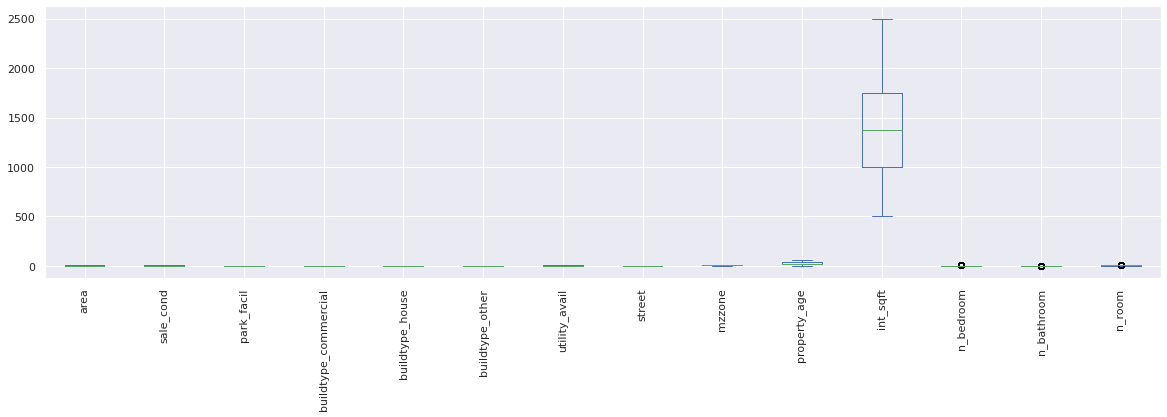

In [14]:
pd.DataFrame(X_train, columns=X_train.columns).plot.box(figsize=(20,5), rot=90)
plt.show()

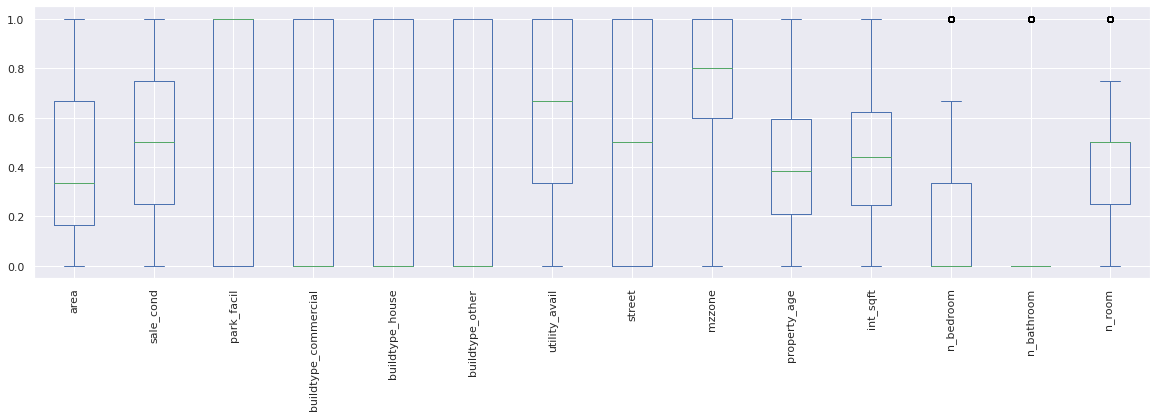

In [15]:
mm = MinMaxScaler().fit(X_train)
X_train_mm = mm.transform(X_train)
X_train_mm = pd.DataFrame(X_train_mm, columns=X_train.columns)
X_test_mm = mm.transform(X_test)
X_test_mm = pd.DataFrame(X_test_mm, columns=X_test.columns)
X_train_mm.plot.box(figsize=(20,5), rot=90)
plt.show()

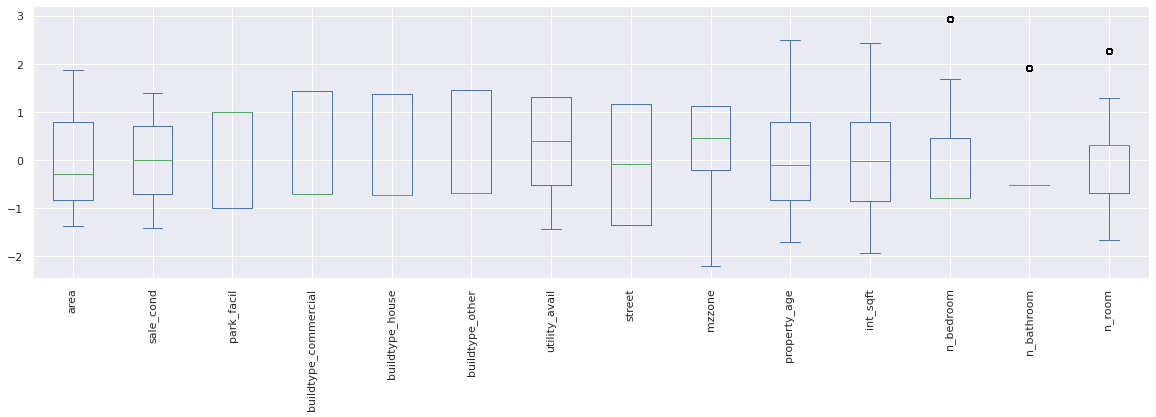

In [16]:
ss = StandardScaler().fit(X_train)
X_train_ss = ss.transform(X_train)
X_train_ss = pd.DataFrame(X_train_ss, columns=X_train.columns)
X_test_ss = ss.transform(X_test)
X_test_ss = pd.DataFrame(X_test_ss, columns=X_test.columns)
X_train_ss.plot.box(figsize=(20,5), rot=90)
plt.show()

#LinearRegression

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('R2- SCORE:', metrics.r2_score(y_test,y_pred))


lr.fit(X_train_ss, y_train)
y_predlrss = lr.predict(X_test_ss)
print('R2- SCORE(Standardscaler):', metrics.r2_score(y_test,y_predlrss))


lr.fit(X_train_mm, y_train)
y_predlrmm = lr.predict(X_test_mm)
print('R2- SCORE(Minmaxscaled):', metrics.r2_score(y_test,y_predlrmm))

R2- SCORE: 0.923424259980204
R2- SCORE(Standardscaler): 0.9235956445666523
R2- SCORE(Minmaxscaled): 0.9234463807033615


#KNearestNeighbors

Orange and Blue depict RSME for MinMaxScaler and blue


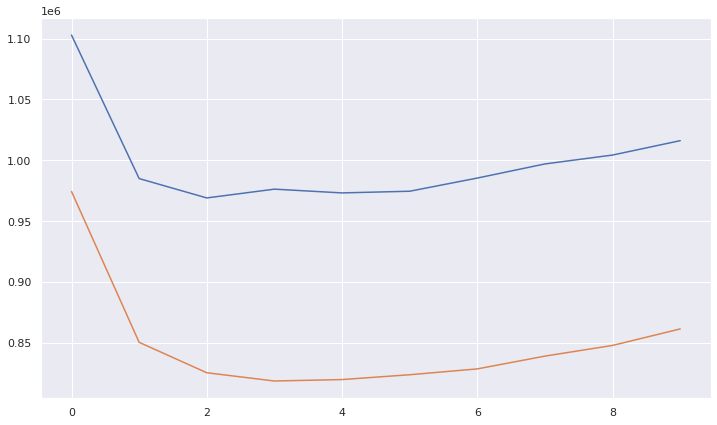

In [18]:
rmse_val = []
for K in range(10):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)
    model.fit(X_train_mm, y_train)
    pred=model.predict(X_test_mm)
    error = sqrt(mean_squared_error(y_test,pred))
    rmse_val.append(error)
curve = pd.DataFrame(rmse_val)

rmse_val1 = []
for K in range(10):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)
    model.fit(X_train_ss, y_train)
    pred=model.predict(X_test_ss)
    error = sqrt(mean_squared_error(y_test,pred))
    rmse_val1.append(error)
curve1 = pd.DataFrame(rmse_val1)

print('Orange and Blue depict RSME for MinMaxScaler and blue')
plt.figure(figsize=(12,7))
plt.plot(curve)
plt.plot(curve1)
plt.show()

In [19]:
knn = KNeighborsRegressor(n_neighbors=100)
knn.fit(X_train, y_train)
y_predknn = knn.predict(X_test)
print('R2- SCORE:', metrics.r2_score(y_test,y_predknn))

knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_train_mm, y_train)
y_predknn_mm = knn.predict(X_test_mm)
print('R2- SCORE(Minmaxscaled):', metrics.r2_score(y_test,y_predknn_mm))

knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(X_train_ss, y_train)
y_predknn_ss = knn.predict(X_test_ss)
print('R2- SCORE(Standardscaler):', metrics.r2_score(y_test,y_predknn_ss))

R2- SCORE: 0.43309895459186276
R2- SCORE(Minmaxscaled): 0.9338292932490762
R2- SCORE(Standardscaler): 0.9527770963012473


#DecisionTree

In [20]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print('R2- SCORE:', metrics.r2_score(y_test,y_pred_dt))

dt.fit(X_train_mm, y_train)
y_pred_dtmm = dt.predict(X_test_mm)
print('R2- SCORE(Minmaxscaled):', metrics.r2_score(y_test,y_pred_dtmm))

dt.fit(X_train_ss, y_train)
y_pred_dtss = dt.predict(X_test_ss)
print('R2- SCORE(Standardscaler):', metrics.r2_score(y_test,y_pred_dtss))

R2- SCORE: 0.9745101699276385
R2- SCORE(Minmaxscaled): 0.9752728602450237
R2- SCORE(Standardscaler): 0.9758335698703445


#Random Forest

In [21]:
rf = RandomForestRegressor(n_estimators= 100, max_depth = 15, max_features='sqrt')
rf.fit(X_train, y_train);
y_pred_rf = rf.predict(X_test)
print('R2- SCORE:', metrics.r2_score(y_test,y_pred_rf))

rf.fit(X_train_mm, y_train);
y_pred_rfmm = rf.predict(X_test_mm)
print('R2- SCORE(minmaxscaled):', metrics.r2_score(y_test,y_pred_rfmm))

rf.fit(X_train_ss, y_train);
y_pred_rfss = rf.predict(X_test_ss)
print('R2- SCORE(Standardscaler):', metrics.r2_score(y_test,y_pred_rfss))


R2- SCORE: 0.9873740571091896
R2- SCORE(minmaxscaled): 0.9869392191467882
R2- SCORE(Standardscaler): 0.9871320526481328


#GradientBoostingRegressor

In [22]:
for lr in [0.1,0.3,0.5,0.8,1]:
  model= GradientBoostingRegressor(learning_rate=lr)
  model.fit(X_train, y_train)
  print("Learning rate : ", lr, " Train score : ", model.score(X_train,y_train), " Test score : ", model.score(X_test,y_test))

Learning rate :  0.1  Train score :  0.9918884151594325  Test score :  0.9912206119939374
Learning rate :  0.3  Train score :  0.997053105407478  Test score :  0.9963500281687723
Learning rate :  0.5  Train score :  0.9977218437506626  Test score :  0.9969436721041329
Learning rate :  0.8  Train score :  0.9977596041412032  Test score :  0.9961684100358977
Learning rate :  1  Train score :  0.9979310033973539  Test score :  0.9966576179286163


In [23]:
gbr = GradientBoostingRegressor(learning_rate=.5)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
print('R2- SCORE:', metrics.r2_score(y_test,y_pred_gbr))

gbr.fit(X_train_mm, y_train)
y_pred_gbrmm = gbr.predict(X_test_mm)
print('R2- SCORE(MinMaxScaler):', metrics.r2_score(y_test,y_pred_gbrmm))

gbr.fit(X_train_ss, y_train)
y_pred_gbrss = gbr.predict(X_test_ss)
print('R2- SCORE(Standardscaler):', metrics.r2_score(y_test,y_pred_gbrss))

R2- SCORE: 0.9969414099583165
R2- SCORE(MinMaxScaler): 0.9969264054354193
R2- SCORE(Standardscaler): 0.9969337372493458


#XGBoost

In [24]:
for lr in [0.2,0.5,0.7,0.8,1]:
  model = xgb.XGBRegressor(learning_rate = lr, n_estimators=100, verbosity = 0)
  model.fit(X_train, y_train)
  print("Learning rate : ", lr, " Train score : ", model.score(X_train,y_train), " Test score : ", model.score(X_test,y_test))

Learning rate :  0.2  Train score :  0.9967270044068283  Test score :  0.9961621441920422
Learning rate :  0.5  Train score :  0.9977452756031117  Test score :  0.9970817256045346
Learning rate :  0.7  Train score :  0.9983913785754902  Test score :  0.9976933662773312
Learning rate :  0.8  Train score :  0.997939920648442  Test score :  0.9964788933275089
Learning rate :  1  Train score :  0.9978139598852349  Test score :  0.996720315945207


In [25]:
xg = xgb.XGBRegressor(learning_rate = .7, n_estimators=100, verbosity = 0)
xg.fit(X_train, y_train)
y_pred_gbr = xg.predict(X_test)
print('R2- SCORE:', metrics.r2_score(y_test,y_pred_gbr))

xg.fit(X_train_mm, y_train)
y_pred_gbrmm = xg.predict(X_test_mm)
print('R2- SCORE(MinMaxScaler):', metrics.r2_score(y_test,y_pred_gbrmm))

xg.fit(X_train_ss, y_train)
y_pred_gbrss = xg.predict(X_test_ss)
print('R2- SCORE(Standardscaler):', metrics.r2_score(y_test,y_pred_gbrss))

R2- SCORE: 0.9976933662773312
R2- SCORE(MinMaxScaler): 0.9976933662773312
R2- SCORE(Standardscaler): 0.9976917294994156


Interpretation:-

After training all models we can see that GradientBoostingRegressor and XGBRegressor outperformed most of the machine learning model and GradientBoostingRegressor give 0.99692 as R2-score and XGBRegressor gives 0.997693 as R2-score. Below is the results of all models trained.

GradientBoostingRegressor give score of 0.99692 as R2-score. XGBRegressor gives score of 0.997693 as R2-score. RandomForestRegressor gives score of 0.987036 as R2-score.
Decision Tree gives score of 0.975124 as R2-score. LinearRegression gives score of 0.923424 as R2-score. KNeighborsRegressor gives score of 0.433098 R2-score.


Conclusion: To see the actual result of the ML alogorithm,  first we have to clean the data and try to get all the features in a suitable format. Sometimes many many variables and features which which carries vital role in predicting the price of the house. Without loosing the crux of the data, we need to clean the data. By doing the EDA we can identify the relationship between the given variables and we can see the weightage of each variables. By training the given dataset in various models we can get the R2 score to evaluate which is the best model among them. For the given dataset the XG Boost model gives the highest RS Square score of more than 99% (99.769% to be exact).